In [3]:
import pandas as pd
from pandas import option_context

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Tuple, Dict, Union, Optional
import random
import glob
random.seed(0)
import re
import json

pd.set_option('max_colwidth', 400) # avoid trimming cells
pd.set_option('display.max_columns', None) # avoid truncating columns
pd.set_option('display.max_rows', None) # avoid truncating rows

In [87]:
def fetch_results_files(dataset='squad', verbose=False):
    result_files = list(Path(f'resources/models/').glob(f'seed_*/ft/*-{dataset}/all_results.json'))

    if verbose:
        for i in result_files:
            print(str(i))
                  
    return result_files

def parse_filepath(fp: Path) -> Tuple:
    """
    extracts model and seed from a filepath such as 'resources/models/seed_1/ft/bart_small-SI_t5/finetune.log'
    """
    parts = fp.parts
    # print(parts)
    try:
        model_parts = parts[4].split('-')
        # print(model_parts)
        if len(model_parts) == 2:
            model = model_parts[0]
            arch = None
        elif len(model_parts) == 4:
            model = model_parts[1]
            if model_parts[2] == 'enc':
                arch = 'E'
        else:
            model = model_parts[1]
            arch = 'ED'
        seed = int(parts[2].split('_')[-1])
    except:
        print(f'Failed to parse model and seed from {fp}')
        model, seed, arch = None, None, None
    return model, arch, seed
        
def load_as_dataframe(files: List[Path], verbose=False) -> pd.DataFrame:
    """
    expects a list of files, e.g. resources/models/seed_1/ft/bart_small-SI_t5/finetune.log
    """
    results = []
    for file in files:
        with open(file, 'r', encoding='utf8') as inf:
            result = json.load(inf)
            result['model'], result['arch'], result['seed'] = parse_filepath(file)
            if verbose:
                print(result)
            results.append(result)
    
    df = pd.DataFrame(results)
    df = df.set_index(['model', 'arch', 'seed'])
    df = df.sort_values(['model', 'arch', 'seed'])
        
    return df

In [162]:
squad_results = fetch_results_files('squad', verbose=False)
df1 = load_as_dataframe(squad_results)
df1

df1g = df1.groupby(['model', 'arch'], as_index=True).agg(
    {'eval_f1': [np.mean, np.std]}
)
df1g = df1g.droplevel(level=0, axis=1) 
df1g

mean       std
model   arch                     
SI_bart E     11.246650  0.452714
        ED    16.685302  5.048812
SI_mass E      9.517532  1.562227
        ED    17.685613  6.209149
SI_t5   E     11.748112  0.306621
        ED    11.422712  0.084248

mean                  std          
arch             E         ED         E        ED
model                                            
SI_bart  11.246650  16.685302  0.452714  5.048812
SI_mass   9.517532  17.685613  1.562227  6.209149
SI_t5    11.748112  11.422712  0.306621  0.084248

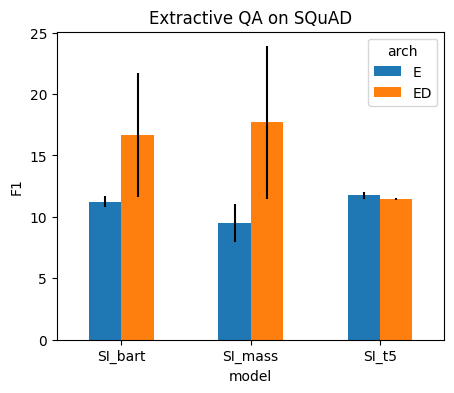

In [188]:
# def plot_squad_scores_v1(df):

#     # print(df.index.get_level_values('model'), df['eval_exact_match']['mean'].values)
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True)
        
#     axes[0].bar(df.index.get_level_values('model'), df['eval_exact_match']['mean'], yerr=df['eval_exact_match']['std'])
#     axes[0].set_title(f"{df.index.get_level_values('arch').unique()[0]} - exact_match")
#     axes[1].bar(df.index.get_level_values('model'), df['eval_f1']['mean'], yerr=df['eval_f1']['std'])
#     axes[1].set_title(f"{df.index.get_level_values('arch').unique()[0]} - f1")
    
#     return

# plot_squad_scores_v1(df1g.iloc[df1g.index.get_level_values('arch') == 'E'])
# plot_squad_scores_v1(df1g.iloc[df1g.index.get_level_values('arch') == 'ED'])

def plot_squad_scores(df, tgt_metric='eval_f1'):
    # print(df.index.get_level_values('model'), df['eval_exact_match']['mean'].values)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 4), sharex=True)
    df = df.unstack(level=1)#.plot(y = "mean", yerr = "std", title = "TRT levels are really important!", color = list("rbg"))
    df.plot(kind='bar', y='mean', yerr='std', figsize=(5,4), title='Extractive QA on SQuAD', ylabel=tgt_metric, ax=axes)
    axes.set_xticklabels(df.index.get_level_values('model'), rotation=0, ha='center')
    return df

plot_squad_scores(df1g, tgt_metric='F1')

In [180]:
squadv2_results = fetch_results_files('squad_v2', verbose=True)
df = load_as_dataframe(squadv2_results)
df
# group_by_cols = ['model', 'arch']
# agg_ops={'eval_exact_match': [np.mean, np.std], 'eval_f1': [np.mean, np.std]}
# dfg = df.groupby(group_by_cols, as_index=True).agg(agg_ops)
# dfg

resources/models/seed_42/ft/bart_small-SI_mass-squad_v2/all_results.json
resources/models/seed_42/ft/bart_small-SI_t5-squad_v2/all_results.json
resources/models/seed_42/ft/bart_small-SI_bart-squad_v2/all_results.json
resources/models/seed_1984/ft/bart_small-SI_mass-squad_v2/all_results.json
resources/models/seed_1984/ft/bart_small-SI_t5-squad_v2/all_results.json
resources/models/seed_1984/ft/bart_small-SI_bart-squad_v2/all_results.json
resources/models/seed_23/ft/bart_small-SI_mass-squad_v2/all_results.json
resources/models/seed_23/ft/bart_small-SI_t5-squad_v2/all_results.json
resources/models/seed_23/ft/bart_small-SI_bart-squad_v2/all_results.json


epoch  eval_HasAns_exact  eval_HasAns_f1  \
model   arch seed                                             
SI_bart ED   23      2.0           0.775978        0.876674   
             42      2.0           1.113360        1.347978   
             1984    2.0           0.000000        0.000000   
SI_mass ED   23      2.0           0.000000        0.000000   
             42      2.0           0.556680        0.747134   
             1984    2.0           1.298920        1.614058   
SI_t5   ED   23      2.0           0.000000        0.000000   
             42      2.0           0.000000        0.000000   
             1984    2.0           0.000000        0.000000   

                   eval_HasAns_total  eval_NoAns_exact  eval_NoAns_f1  \
model   arch seed                                                       
SI_bart ED   23                 5928         99.428091      99.428091   
             42                 5928         98.250631      98.250631   
             1984               5928        100.000000     100.000000   
SI_mass ED   23                 5928        100.000000     100.000000   
             42                 5928         99.360807      99.360807   
             1984               5928         98.402019      98.402019   
SI_t5   ED   23                 5928        100.000000     100.000000   
             42                 5928        100.000000     100.000000   
             1984               5928        100.000000     100.000000   

                   eval_NoAns_total  eval_best_exact  eval_best_exact_thresh  \
model   arch seed                                                              
SI_bart ED   23                5945        50.223195                     0.0   
             42                5945        50.088436                     0.0   
             1984              5945        50.071591                     0.0   
SI_mass ED   23                5945        50.071591                     0.0   
             42                5945        50.113703                     0.0   
             1984              5945        50.138971                     0.0   
SI_t5   ED   23                5945        50.071591                     0.0   
             42                5945        50.071591                     0.0   
             1984              5945        50.071591                     0.0   

                   eval_best_f1  eval_best_f1_thresh  eval_exact    eval_f1  \
model   arch seed                                                             
SI_bart ED   23       50.267856                  0.0   50.172661  50.222937   
             42       50.094051                  0.0   49.751537  49.868678   
             1984     50.071591                  0.0   50.071591  50.071591   
SI_mass ED   23       50.071591                  0.0   50.071591  50.071591   
             42       50.169208                  0.0   50.029479  50.124569   
             1984     50.201508                  0.0   49.919987  50.077330   
SI_t5   ED   23       50.071591                  0.0   50.071591  50.071591   
             42       50.071591                  0.0   50.071591  50.071591   
             1984     50.071591                  0.0   50.071591  50.071591   

                   eval_samples  eval_total  train_loss  train_runtime  \
model   arch seed                                                        
SI_bart ED   23           18661       11873    2.581477      4378.4957   
             42           18661       11873    2.569578      4431.8799   
             1984         18661       11873    2.619904      4395.5085   
SI_mass ED   23           18661       11873    2.816377      4278.2318   
             42           18661       11873    2.717911      4253.3274   
             1984         18661       11873    2.682323      4237.8129   
SI_t5   ED   23           18661       11873    2.667575      4442.6969   
             42           18661       11873    2.699780      4401.3427   
             1984         1866